# Kickstarter project (need to spell check)
## Our project for this semester is to try and predict whether a fundraising campaign in kickstarter will succeed or not.

This type of prediction can actualy be useful in several scenarios, whether for an entrepreneur trying to evaluate his chances, the kickstarter company itself that would like to promote promising campaigns or for an investor considering backing a company.

There are a few datasets available in kaggle such as: [here](https://www.kaggle.com/codename007/funding-successful-projects) and [here](https://www.kaggle.com/kemical/kickstarter-projects). These datasets are more limited timespan wise and in their richness of data. The dataset that we used in our project is offered [here](https://webrobots.io/kickstarter-datasets/). It is very large and somewhat messy, so our first steps are going to be devoted to get to know this dataset and clean it up so we can use it easily.

The data is scraped over different periods, the last scrape is from Nov 2019 and contains 57 very large csv files. Our first step would be to unify it all (scrapes from 2015 onwards each containing about 100,000 records, with alot of overlaping) into a single dataframe, and explore the columns.
If this looks alright, we'll add a few other generations to the data set and then start sanitzing it.


# Note that this will download dataset of about 800MB and extract about 5GB of space on your computer.

After dataset is saved as pickle, there is no longer a need for the extracted csv files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dataCleaning as dc
import visio
import seaborn as sns
%matplotlib inline

In [2]:
df = dc.make_dataframe(path=r'rawData') #Files are assumed to be located in rawData sub.dir. caches pickle in cwd.
#print first few rows
df.head()

read dataframe from cache rick.pickle


,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,staff_pick,state,state_changed_at,static_usd_rate,total_hits,unread_messages_count,unseen_activity_count,urls,usd_pledged,usd_type
351939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,19884.0,NaN,NaN,NaN,NaN,NaN
0,68.0,An anthology of stories about Girls and mythic...,"{""id"":324,""name"":""Anthologies"",""slug"":""publish...",2914.0,CA,Canada,1.568573e+09,"{""id"":1114868812,""name"":""Alex McGilvery"",""slug...",CAD,$,...,False,successful,1.573710e+09,0.757088,NaN,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",2925.608515,domestic
1,0.0,This horror short film is about a school camp ...,"{""id"":297,""name"":""Horror"",""slug"":""film & video...",0.0,AU,Australia,1.572763e+09,"{""id"":132169953,""name"":""LouisB"",""slug"":""louisb...",AUD,$,...,False,live,1.573706e+09,0.684319,NaN,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international
2,0.0,"I designed a mouse that can generate heat, it ...","{""id"":337,""name"":""Gadgets"",""slug"":""technology/...",0.0,HK,Hong Kong,1.570872e+09,"{""id"":736392141,""name"":""Zhijian Yijia"",""slug"":...",HKD,$,...,False,live,1.573705e+09,0.127696,NaN,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,NaN
3,5.0,"""The clothing brand which that brings to life ...","{""id"":263,""name"":""Apparel"",""slug"":""fashion/app...",11.0,ES,Spain,1.571086e+09,"{""id"":1577671901,""name"":""Fran Domínguez"",""slug...",EUR,€,...,False,failed,1.573704e+09,1.103099,NaN,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",11.030989,domestic


Great! Let's get a few details about this data: What are the features, how many records exist:

In [3]:
cols = list(df.columns.values)
print(cols)
num_recs = len(df.index)
print()
print('There are originaly ', f'{num_recs:,}' , 'records in data')

['backers_count', 'blurb', 'category', 'converted_pledged_amount', 'country', 'country_displayable_name', 'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'deadline', 'disable_communication', 'friends', 'fx_rate', 'goal', 'has_more', 'id', 'is_backing', 'is_starrable', 'is_starred', 'last_update_published_at', 'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged', 'profile', 'projects', 'search_url', 'seed', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'total_hits', 'unread_messages_count', 'unseen_activity_count', 'urls', 'usd_pledged', 'usd_type']

There are originaly  351,940 records in data


Taking a first peek at the data via Excel hints that there are many empty columns:
![peek](img/firstPeek.png)

Let's see what columns contain mostly null values:


In [4]:
nes = df.isna().sum()
print(nes)

backers_count                    1
blurb                           19
category                         1
converted_pledged_amount    241667
country                          1
country_displayable_name    340125
created_at                       1
creator                          1
currency                         1
currency_symbol                  1
currency_trailing_code           1
current_currency            241667
deadline                         1
disable_communication            1
friends                     350169
fx_rate                     246632
goal                             1
has_more                    351939
id                               1
is_backing                  350169
is_starrable                236264
is_starred                  350169
last_update_published_at    351940
launched_at                      1
location                      1106
name                             4
permissions                 350289
photo                            1
pledged             

We're not missing anything too important so far (though some sound important they are either not used or interchangable with other fields that are kept). Off with their head!

In [5]:
empty = {'friends','is_backing','is_starred','is_starrable','permissions','country_displayable_name','converted_pledged_amount',
         'current_currency','usd_type','fx_rate', 'has_more','last_update_published_at','projects','search_url','seed','staff_pick','total_hits','unread_messages_count','unseen_activity_count'}
letgo = [name for name in empty if name in cols]
df.drop(columns=letgo,inplace=True)
cols = list(df.columns.values)
print(cols)

['backers_count', 'blurb', 'category', 'country', 'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'deadline', 'disable_communication', 'goal', 'id', 'launched_at', 'location', 'name', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state', 'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged']


We can already see redundant attributes which we are sure we will not need:
- Data that is used for display purpases: such as 'currency_symbol', 'currency_trailing_code'.
- Data that is biased: such as backers count (This is part of the prediction), or disable_communication which is an option for failed projects 
- Data that will not be used by our model: location, 'profile', 'urls','usd_type', 'location'.
Let's start with dropping these.

Looks like we can drop 'friends','is_backing','is_starred','permissions' as they are basicaly empty.

In [6]:
redundant = {'backers_count','currency_symbol', 'currency_trailing_code','source_url','disable_communication',
             'profile','urls','location','spotlight','usd_pledged'}
letgo = [name for name in empty if name in cols]
df.drop(columns=letgo, inplace=True)
cols = list(df.columns.values)
print(cols)

['backers_count', 'blurb', 'category', 'country', 'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'deadline', 'disable_communication', 'goal', 'id', 'launched_at', 'location', 'name', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state', 'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged']


From looking at the data we can also see that the time fields are given in UNIX time. It'll be usefull ahead if we can break each date into a day month year trio. We'll run the conversion and replace each column with the corresponding 3 fields.

In [7]:
timefields = ['created_at','deadline','launched_at','state_changed_at']
df.dropna(axis = 0, how = 'any', subset = timefields, inplace = True) # Let go of values with missing times
dc.convert_time(df,timefields)
print('sanity check')
df.head()

sanity check


,backers_count,blurb,category,country,created_at,creator,currency,currency_symbol,currency_trailing_code,deadline,...,pledged,profile,slug,source_url,spotlight,state,state_changed_at,static_usd_rate,urls,usd_pledged
0,68.0,An anthology of stories about Girls and mythic...,"{""id"":324,""name"":""Anthologies"",""slug"":""publish...",CA,2019-09-15 18:37:57,"{""id"":1114868812,""name"":""Alex McGilvery"",""slug...",CAD,$,True,2019-11-14 05:35:09,...,3864.29,"{""id"":3813769,""project_id"":3813769,""state"":""in...",mythical-girls,https://www.kickstarter.com/discover/categorie...,True,successful,2019-11-14 05:35:10,0.757088,"{""web"":{""project"":""https://www.kickstarter.com...",2925.608515
1,0.0,This horror short film is about a school camp ...,"{""id"":297,""name"":""Horror"",""slug"":""film & video...",AU,2019-11-03 06:38:09,"{""id"":132169953,""name"":""LouisB"",""slug"":""louisb...",AUD,$,True,2019-12-14 12:59:00,...,0.00,"{""id"":3845194,""project_id"":3845194,""state"":""in...",kill-die-or-survive,https://www.kickstarter.com/discover/categorie...,False,live,2019-11-14 04:39:34,0.684319,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000
2,0.0,"I designed a mouse that can generate heat, it ...","{""id"":337,""name"":""Gadgets"",""slug"":""technology/...",HK,2019-10-12 09:25:29,"{""id"":736392141,""name"":""Zhijian Yijia"",""slug"":...",HKD,$,True,2019-12-14 04:18:15,...,0.00,"{""id"":3831195,""project_id"":3831195,""state"":""in...",a-mouse-that-can-warm-your-hands-in-winter,https://www.kickstarter.com/discover/categorie...,False,live,2019-11-14 04:18:16,0.127696,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000
3,5.0,"""The clothing brand which that brings to life ...","{""id"":263,""name"":""Apparel"",""slug"":""fashion/app...",ES,2019-10-14 20:49:25,"{""id"":1577671901,""name"":""Fran Domínguez"",""slug...",EUR,€,False,2019-11-14 04:04:51,...,10.00,"{""id"":3832688,""project_id"":3832688,""state"":""in...",postugramer,https://www.kickstarter.com/discover/categorie...,False,failed,2019-11-14 04:04:51,1.103099,"{""web"":{""project"":""https://www.kickstarter.com...",11.030989
4,2.0,Soy for joy.,"{""id"":343,""name"":""Candles"",""slug"":""crafts/cand...",SG,2019-09-30 08:55:30,"{""id"":592619042,""name"":""Talitha Kumia Darmo"",""...",SGD,$,True,2019-11-14 04:00:00,...,4.00,"{""id"":3823347,""project_id"":3823347,""state"":""in...",kandel-sustainable-scented-candles,https://www.kickstarter.com/discover/categorie...,False,failed,2019-11-14 04:00:01,0.733089,"{""web"":{""project"":""https://www.kickstarter.com...",2.932358


Cool! looks alot better. now, one more check we need to do, is to check for duplicates in our dataset. If we find any duplicates (by project id). We will drop all earlier appearances of the same project. Note that this action sorts all projects by update date, so we need to take that in consideration up ahead. The first method we used was supposed to take care of this, but just to be sure...

In [8]:
print('There were originaly ', f'{num_recs:,}' , 'records in data')
dc.remove_duplicates(df)
num_recs = len(df.index)
print('After processing there are ', f'{num_recs:,}' , 'records in data')

There were originaly  351,940 records in data
After processing there are  351,939 records in data


Another inconviniency in this dataset is that some of the fields are given in json form, specificaly the 'catagory' and 'creator' attributs. We'll parse just the interesting parts out of these fields and remove all bloat text.

In [9]:
#dc.extract_creator(df) #replaces the creator json with creator id int, un
df.drop(columns=['creator'], inplace=True) #currently not used.
dc.extract_catagories(df) #gets project catagory data

One last thing that remains is to convert the goal amount which is the project's local currency (and not usd).
Once this is done we no longer need the static usd column (it is dropped by the function). We will also parse the project photo url for future use.

In [ ]:
dc.convert_goal(df)
dc.get_image_url(df)
df.head()

Now we are ready to begin exploring our data.
As this is basicaly what we are asking, let's see how many projects of each status are in our dataset.

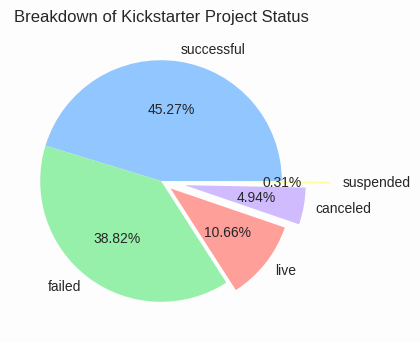

In [10]:
visio.plot_distriubtion_by_state_slice(df)

Since live projects can't be used, we'll clear them out and also unite suspended and canceled project to be labled as failed. which gives us:

successful    159328
failed        155087
Name: state, dtype: int64


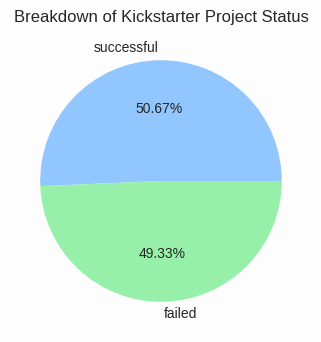

After processing there are  314,415 records in data


In [11]:
dc.fix_state(df) #deletes live projects and unites failed.
df.reset_index(drop=True, inplace=True)
print(df.state.value_counts())
visio.plot_distriubtion_by_state_slice(df, explode = [0,0])
num_recs = len(df.index)
print('After processing there are ', f'{num_recs:,}' , 'records in data')


Cool. Looks like our data is balanced, and projects in our data set are eaqualy likely to fail or succeed.

Now, let's take a look at how our data distributes globaly.
projects by origin country:

In [ ]:
visio.plot_success_by_country(df)

Thoose americans are always too big, let's try and give focus to the rest of the world as well:

In [ ]:
visio.plot_success_by_country(df.loc[df['country'] != 'US'])

Let's see how success distributes by catagory:

In [ ]:
visio.plot_success_by_category(df)

It seems as product catagory has an impact on campaign result. Our data set allows us to view this in even finer granularity, by sub catagories:

In [ ]:
visio.plot_success_by_sub_category(df)

Another thing to factor in is seasonality, let's see if there is any change in the success depending on project start month. To be able to look at this data over several years, we'll add specific month and year columns for launched_at and deadline. We will also add a field calculating the delta in months between launch and deadline.

In [ ]:
dc.extract_month_and_year(df, ['launched_at','deadline'])
dc.add_destination_delta_in_days(df)
visio.plot_success_by_launched_month(df)

Overall, looking at the whole period of given data:

In [ ]:
visio.plot_success_over_time(df)

Let's see how the duration of the campaign affects the probability of success.

In [ ]:
visio.plot_success_by_destination_delta_in_days(df)

In [ ]:
inner = df.loc[df['goal']<30000]
sns.distplot(inner['goal']).set(xlim=(0))
print('number of records out of range:',len(df.loc[df['goal']>30000]))

In [ ]:
inner = df.loc[df['goal']>30000]
inner = inner.loc[df['goal']<200000]
sns.distplot(inner['goal']).set(xlim=(0))
#print('number of records out of range:',len(df.loc[df['goal']<50000]))

In [ ]:
inner = df.loc[df['goal']<80000]
sns.distplot(inner['goal']).set(xlim=(0))
print('number of records out of range:',len(df.loc[df['goal']>80000]))

In [ ]:
cent = df.loc[df['goal']<30000]
cent.plot.scatter(x='goal',y='pledged')

Now, Let's try running a few naive models and see what it is that we are dealing with here.

In [ ]:
import knn_model as knn
import logistic_regression_model as logistic
import random_forest_model as forest
import gradient_boosting_model as gradient_boosting

In [ ]:
logReg_pr = logistic.run_model(df)
models = {'Logistic regression' : logReg_pr}

Let's try a few other models: KNN, Random forest and gradient boosting.

In [ ]:
knn_pr = knn.run_model(df,18)
models['KNN'] = knn_pr

In [ ]:
forest_pr = forest.run_model(df,950)
models['Random forest'] = forest_pr

In [ ]:
boost_pr = gradient_boosting.run_model(df, 1000)
models['Gradient boost'] = boost_pr

In [ ]:
visio.plot_precision(models)

In [ ]:
df.to_pickle('cleaned.pickle')

In [ ]:
dc.get_image_url(df)